In [3]:
# Cell In[0]: Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Visualization for missing data
import missingno as msno

# Utility functions and classes
from utils import nunique_per_cat
from preprocess import PreprocessMIMIC

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Add other sklearn imports as needed

In [4]:
# modify this to direct to the data stored locally
file_paths = {
    'edstays': "ED/edstays.csv",
    'admissions': "HOSP/admissions.csv",
    'transfers': "HOSP/transfers.csv",
    'diagnosis': "ED/diagnosis.csv",
    'triage': "ED/triage.csv",
    'vitalsigns': 'ED/vitalsign.csv',
    'medrecon': 'ED/medrecon.csv',
    'patients': 'HOSP/patients.csv'
}

In [5]:
patients_df = pd.read_csv(file_paths['patients'])
patients_df.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000058,F,33,2168,2020 - 2022,NaN
3,10000068,F,19,2160,2008 - 2010,NaN
4,10000084,M,72,2160,2017 - 2019,2161-02-13


## Analyze relationship between number of transfers and length of stay

In [9]:
transfers_df.head()

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27
2,10000032,22595853.0,36904543,discharge,UNKNOWN,2180-05-07 17:21:27,NaN
3,10000032,22841357.0,34100253,discharge,UNKNOWN,2180-06-27 18:49:12,NaN
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12


In [8]:
# Load Transfers Data
transfers_df = pd.read_csv(file_paths['transfers'])

# Preprocess the data
preprocess = PreprocessMIMIC(file_paths)


# Convert datetime columns
transfers_df['intime'] = pd.to_datetime(transfers_df['intime'])
transfers_df['outtime'] = pd.to_datetime(transfers_df['outtime'])

# Calculate Length of Stay (LOS) in hours
transfers_df['los'] = (transfers_df['outtime'] - transfers_df['intime']).dt.total_seconds() / 3600

TypeError: __init__() takes 1 positional argument but 2 were given

In [16]:

# Function to Analyze Patient Movement
def analyze_patient_movement(df):
    """
    Summarizes patient movement data by subject_id and hadm_id.
    
    Parameters:
        df (DataFrame): Transfers DataFrame.
        
    Returns:
        DataFrame: Summary of patient movements.
    """
    patient_stays = df.groupby(['subject_id', 'hadm_id'])
    
    movement_summary = patient_stays.agg(
        num_transfers=('eventtype', 'count'),
        total_los=('los', 'sum'),
        num_units=('careunit', 'nunique')
    )
    
    movement_summary['avg_time_per_unit'] = movement_summary['total_los'] / movement_summary['num_units']
    
    return movement_summary

# Generate Movement Summary
movement_summary = analyze_patient_movement(transfers_df)

# Display Summary Statistics
print("Summary of patient movement:")
print(movement_summary.describe())

Summary of patient movement:
       num_transfers      total_los      num_units  avg_time_per_unit
count  546025.000000  546025.000000  546025.000000      546025.000000
mean        3.671268     118.920617       3.207408          36.912997
std         1.466438     188.122255       0.866075          59.157673
min         1.000000       0.000000       1.000000           0.000000
25%         3.000000      31.754722       3.000000          10.990833
50%         3.000000      71.919722       3.000000          23.114259
75%         4.000000     138.994167       3.000000          42.691111
max        34.000000   52894.029444      14.000000       17631.343148



Average time spent in each unit:
                                                        mean     median  \
careunit                                                                  
Emergency Department                                7.038319   5.339722   
Medicine                                           69.081396  43.529167   
Emergency Department Observation                    4.742284   0.445556   
Discharge Lounge                                   10.827407  12.519167   
Med/Surg                                           66.872366  42.955000   
Medicine/Cardiology                                58.669751  36.877778   
Neurology                                          64.780727  42.077917   
Transplant                                         82.474241  47.977778   
Hematology/Oncology                               101.543491  55.179167   
PACU                                                6.166163   2.685972   
Vascular                                           58.885385  38.9

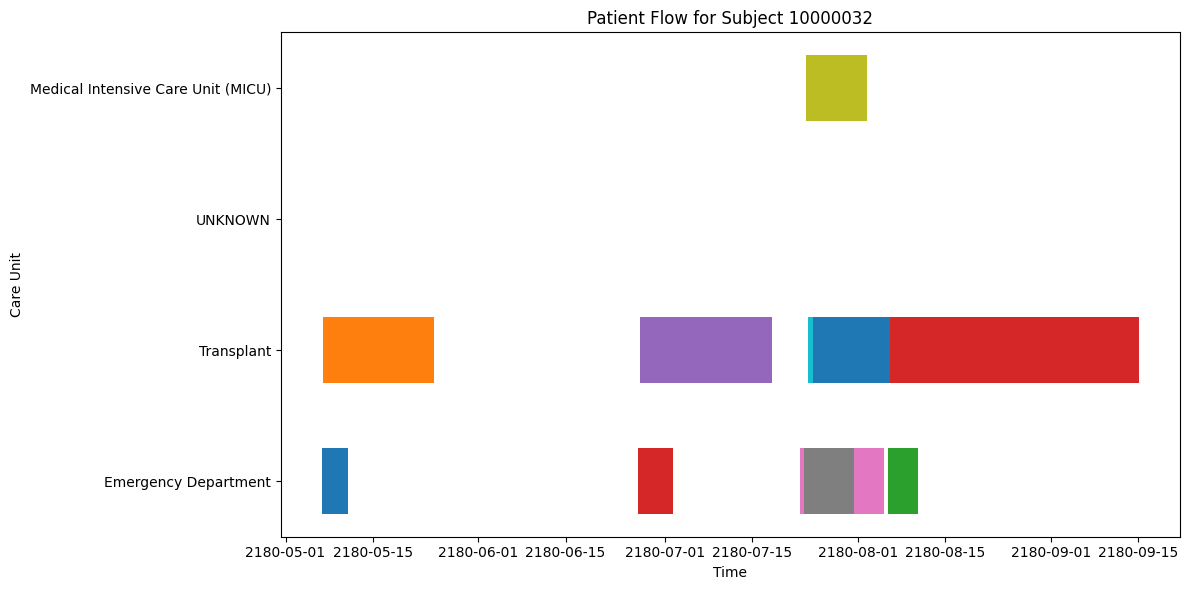

In [17]:

# Calculate Average Time Spent in Each Unit
unit_time = transfers_df.groupby('careunit')['los'].agg(['mean', 'median', 'count']).sort_values('count', ascending=False)

print("\nAverage time spent in each unit:")
print(unit_time)

# Function to Plot Patient Flow
def plot_patient_flow(df, patient_id):
    """
    Plots the flow of a patient through different care units over time.
    
    Parameters:
        df (DataFrame): Transfers DataFrame.
        patient_id (int): Subject ID of the patient.
    """
    patient_data = df[df['subject_id'] == patient_id].sort_values('intime')
    
    plt.figure(figsize=(12, 6))
    
    for _, row in patient_data.iterrows():
        plt.barh(row['careunit'], row['los'], left=row['intime'], height=0.5)
    
    plt.title(f'Patient Flow for Subject {patient_id}')
    plt.xlabel('Time')
    plt.ylabel('Care Unit')
    plt.tight_layout()
    plt.show()

# Example: Plot Flow for the First Patient
first_patient = transfers_df['subject_id'].iloc[0]
plot_patient_flow(transfers_df, first_patient)

In [18]:

# Analyze Common Patient Pathways
def get_patient_pathway(group):
    """
    Constructs a pathway string for a patient's care units.
    
    Parameters:
        group (DataFrame): Grouped DataFrame for a patient.
        
    Returns:
        str: Pathway string.
    """
    return ' -> '.join(group['careunit'])

patient_pathways = transfers_df.sort_values('intime').groupby('subject_id').apply(get_patient_pathway)
common_pathways = patient_pathways.value_counts().head(10)

print("\nMost common patient pathways:")
print(common_pathways)



Most common patient pathways:
Emergency Department                                                                            112290
Emergency Department -> Emergency Department                                                     18295
Emergency Department -> Emergency Department Observation -> UNKNOWN                              16179
Emergency Department -> Medicine -> UNKNOWN                                                       7686
Emergency Department -> Emergency Department -> Emergency Department                              5611
Emergency Department -> Neurology -> UNKNOWN                                                      2744
Emergency Department -> Med/Surg -> UNKNOWN                                                       2363
Emergency Department -> Med/Surg/Trauma -> UNKNOWN                                                2316
Emergency Department -> Emergency Department -> Emergency Department -> Emergency Department      2254
Emergency Department -> Surgery/Trauma -> 

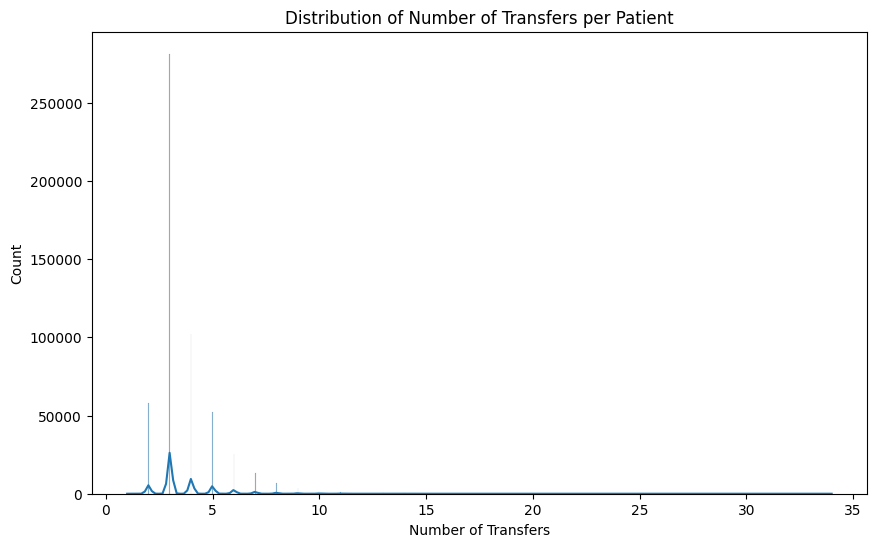

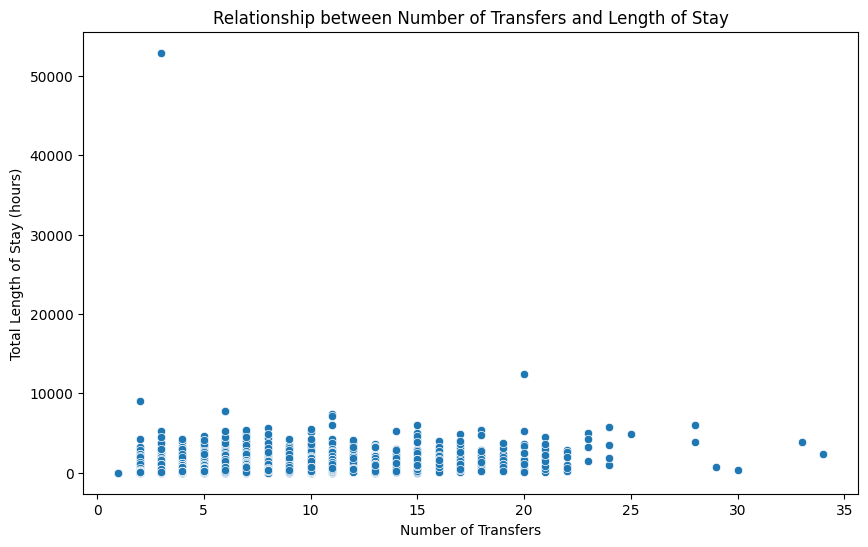

In [19]:

# Visualize Distribution of Number of Transfers
plt.figure(figsize=(10, 6))
sns.histplot(movement_summary['num_transfers'], kde=True)
plt.title('Distribution of Number of Transfers per Patient')
plt.xlabel('Number of Transfers')
plt.ylabel('Count')
plt.show()

# Analyze Relationship Between Number of Transfers and Length of Stay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_transfers', y='total_los', data=movement_summary)
plt.title('Relationship between Number of Transfers and Length of Stay')
plt.xlabel('Number of Transfers')
plt.ylabel('Total Length of Stay (hours)')
plt.show()